Module 5, Lab 4 - Factorial Designs
===================================

In this lab, we will explore the factorial experiment. I analyze the
data from the previous lab but using a factorial design. I assume you
are familiar with the between subjects lab, conducted previously. In
this lab, we consider whether the three logos have different effects for
males or females, a question which marketing wants to know prior to
pushing the ad to different markets.

Before we begin, I will load the packages required to run this notebook:

In [1]:
## LOAD PACKAGES 
import pandas as pd
import numpy as np
import scipy.stats as ss
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.factorplots import interaction_plot
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Next, the dataset is loaded and the sentiment is computed:

In [2]:
## Load the dataset
dat = pd.read_csv("datasets/logos.csv")

## Remove rows with missing values 
dat.dropna(subset = ['logo'], inplace = True)

## Compute sentiment and look at the head of the data frame.
dat['sentiment'] = dat[['friendly', 'inviting', 'interesting', 'positive', 'pleasant']].apply(np.mean, axis = 1)
dat.head()

,id,friendly,inviting,interesting,positive,pleasant,sex,logo,sentiment
0,3,9,8,9,10,9,f,Logo A,9.0
1,98,7,6,8,7,7,f,Logo C,7.0
2,73,5,3,6,6,6,m,Logo C,5.2
3,89,4,5,2,3,4,f,Logo C,3.6
4,13,8,7,9,8,6,f,Logo A,7.6


Finally, we need the specialized Python pyDOE package for designed experiments, which must be installed and imported:

Vizualize the Data + Run Descriptives
=====================================

In a factorial design, we randomly assign a second treatment in addition
to the first. For example, we could also make 50% of the logos in color
and 50% in grey scale. Thus we would randomly assign people to one of
the designs (3 levels: A, B, and C) and one of the colors (2 levels:
color, grey scale). For this reason, this is referred to as a 2 x 3
factorial design.

One need not randomly assign the variable. One can also use a
pre-existing grouping variable, such as sex. One caveat is needed,
however; if the grouping variable was not randomly assigned to
participants (e.g., favorite color), we cannot be sure if any observed
effect is due to that variable or something else that might be causing
it. For example, if participants who love the color purple tend to
prefer Logo B, we don't know if that logo preference is due to the color
or something else that might cause that color preference (see the
discussion on prior causes in the regression lab).

In our case, we will examine a 2 (sex: male, female) x 3 (logo: A, B, C)
design. These combinations define our *factorial design**.
Although it is true that sex was not randomly assigned by the
research team to participants, biological sex is randomly assigned at
birth and has no known prior causes. Thus, any differences we see
between the sexes can be ultimately assumed to result from sex.

We can easily visualize our data using the seaborn package. You already performed visualization of sentiment by logo in a previous lab. Now, you can create a visualization by sex. 

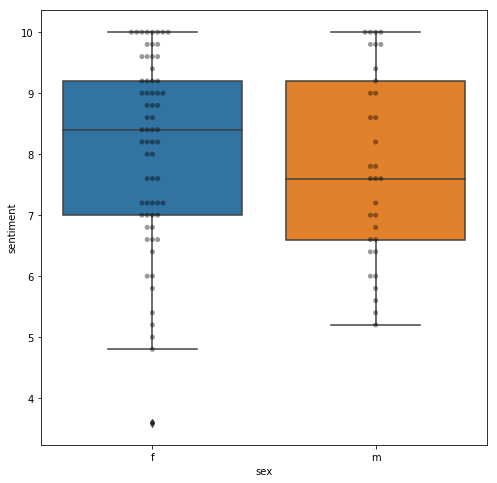

In [3]:
ax = plt.figure(figsize=(8,8)).gca() # define axis
sns.boxplot(x = 'sex', y = 'sentiment', data = dat, ax = ax)
sns.swarmplot(x = 'sex', y = 'sentiment', color = 'black', data = dat, ax = ax, alpha = 0.4)

There is not a great deal of difference in sentiment by sex. 

Now, you will visualize the interaction between sentiment and logo and sex. In this case we use the `hue` arguments to differentiate between male and female:

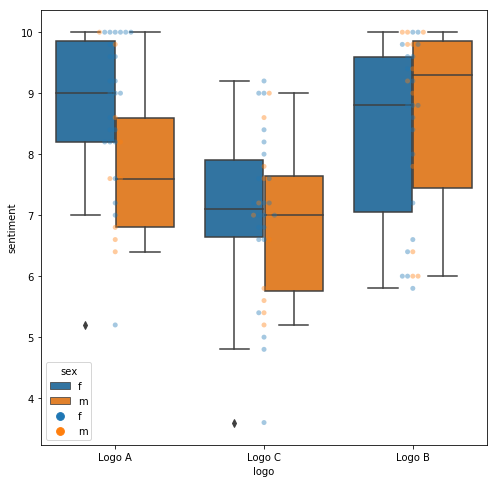

In [4]:
ax = plt.figure(figsize=(8,8)).gca() # define axis
sns.boxplot(x = 'logo', y = 'sentiment', data = dat, hue = 'sex', ax = ax)
sns.swarmplot(x = 'logo', y = 'sentiment', hue = 'sex', data = dat, ax = ax, alpha = 0.4)

We do not see any large systematic differences in the overall levels of
sentiment for males or females, nor do we see a substantively different
pattern of liking across the three logos for males or females. Thus,
perhaps sex does not matter much. 

The Pandas `groupby` method can operate on multiple grouping columns. The code in the cell below groups the data by levels of both `logo` and `sex` and then computes and displays the mean and standard deviation:

In [5]:
dat_grouped = dat[['sentiment','logo','sex']].groupby(['logo','sex'])
print('The means of the groups:')
print(dat_grouped.mean())
print('\n')
print('The standard deviations of the groups:')
print(dat_grouped.std())

The means of the groups:
            sentiment
logo   sex           
Logo A f     8.808333
       m     7.955556
Logo B f     8.340000
       m     8.616667
Logo C f     7.054545
       m     6.900000


The standard deviations of the groups:
            sentiment
logo   sex           
Logo A f     1.197794
       m     1.318248
Logo B f     1.471269
       m     1.621354
Logo C f     1.403644
       m     1.237299


As you could see from the box plots, there is some difference in the means of these groups. Additionally, the variance of the groups varies a fair amount. This lack of *homogeneity of variance* between the groups violates one of the assumptions of ANOVA and may prove to be a problem.  

Next, we can conduct the factorial ANOVA. In general, the ANOVA assesses
whether:

1.  There are significant differences between the two sexes (similar to
    a one-way ANOVA or t-test)
2.  There are significant differences between the three logos (similar
    to a one-way ANOVA or t-test)
3.  The two variables interact

I consider these three questions next.

Example with Interaction Term:
==============================

Now we need to create an ANOVA model with the *interaction term* between `sex` and `logo`. An interaction term is just what you might think. Interactions are cases where "one variable influences the effect of
another." So, the sex x logo interaction is asking: "is there a
different pattern of differences between the logos for males than for
females?" This is not the same as asking whether males or females have
different levels of sentiment. Instead, we are asking whether the effect
of `logo` is different at different levels of `sex`. You can also reverse this. This is the same as asking whether the effect
of `sex` is different across the three `logos`. An interaction is
essentially one variable influencing the effectiveness of another.

Factorial ANOVA designs can get tricky. The best way to conduct the
analysis for real-world data in Python is to use the `ols` function from statsmodels.formula.api package. The `anova_lm` function from the statsmodels.stats.anova package is then applied to the linear model object created with `ols` We need to select the "type" of ANOVA analysis. Since we are including an interaction term in our design we will use `type = 3`. 

Note that the strictly speaking, the
`aov_lm()` model assumes perfectly
balanced factorial designs (equal numbers of people in every permutation
of the experiment, no missing data). This assumption is not adhered to in this case. 

The `ols` function uses a *model formula* of the form:

$$dependent variable \sim independent_var1\ +\ independent_var2\ + \ldots +\ independent_var1:independent_var2 \\
where\\
independent_var1:independent_var2 = interaction\ term$$

Such model formulas give us a great deal of flexibility in defining factorial design of our experiment:

In [6]:
formula = 'sentiment ~ C(logo) + C(sex) + C(logo):C(sex)'
lm_model = ols(formula, dat).fit()
aov_table = anova_lm(lm_model, typ=2)
print(aov_table)

                    sum_sq    df          F    PR(>F)
C(logo)          50.649749   2.0  13.446086  0.000007
C(sex)            1.015771   1.0   0.539318  0.464563
C(logo):C(sex)    4.503817   2.0   1.195637  0.307118
Residual        175.159768  93.0        NaN       NaN


What can you make of this output? You can be interpret these results as follows:

1.  There is not a significant sex difference overall, since the F-statistic is small and the p-value is large. 
2.  There are significant differences between the logos, since the F-statistic is large and the p-value is small. 
3.  There is not a significant "interaction" between sex and logo, since the F-statistic is small and the p-value is large.

It's worth remembering that a non-significant effect does *not* mean
that there is zero effect. We can easily see the 95% CIs for our
"non-significant" effects with Tukey's HSD test. This must be done in two steps:

1. Create a new variable which represents the interaction term before `sex` and `logo`.
2. Compute and display the results of the Tukey HSD on the interaction term. 

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff  lower   upper  reject
-----------------------------------------------
LogoA_f LogoA_m -0.8528  -2.4137  0.7082 False 
LogoA_f LogoB_f -0.4683  -1.6774  0.7408 False 
LogoA_f LogoB_m -0.1917  -1.6036  1.2203 False 
LogoA_f LogoC_f -1.7538  -2.9325  -0.575  True 
LogoA_f LogoC_m -1.9083  -3.3203 -0.4964  True 
LogoA_m LogoB_f  0.3844  -1.2185  1.9874 False 
LogoA_m LogoB_m  0.6611  -1.0999  2.4221 False 
LogoA_m LogoC_f  -0.901  -2.4812  0.6792 False 
LogoA_m LogoC_m -1.0556  -2.8165  0.7054 False 
LogoB_f LogoB_m  0.2767  -1.1816  1.7349 False 
LogoB_f LogoC_f -1.2855  -2.5193 -0.0516  True 
LogoB_f LogoC_m  -1.44   -2.8982  0.0182 False 
LogoB_m LogoC_f -1.5621  -2.9953  -0.129  True 
LogoB_m LogoC_m -1.7167   -3.347 -0.0863  True 
LogoC_f LogoC_m -0.1545  -1.5877  1.2786 False 
-----------------------------------------------


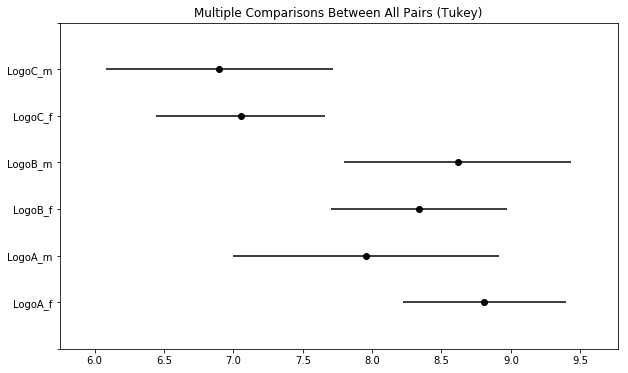

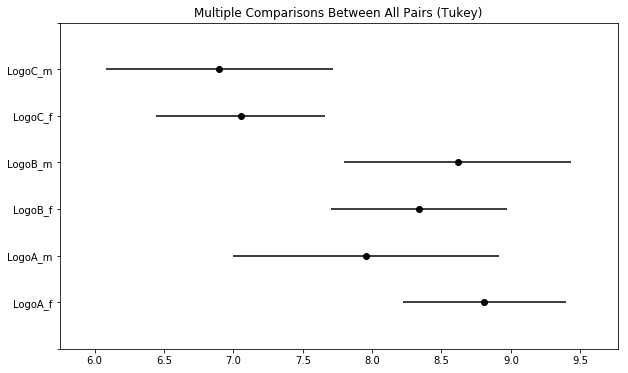

In [7]:
## Create a new variable to represent the interaction term
dat['logo_sex'] = [x.replace(" ", "") + '_' + y for x,y in zip(dat.logo,dat.sex)]

# Run the Tukey HDS test using the interaction variable and display the results
Tukey_HSD = pairwise_tukeyhsd(dat.sentiment,dat.logo_sex)
print(Tukey_HSD)
Tukey_HSD.plot_simultaneous()

For the most part, it is the differences between logo C and the other logos that are significant, for either sex. The one exception, is logo A for male subjects which has an exceptionally wide confidence interval. 